In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd

import os 
from keras.layers import Conv1D, MaxPooling1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/8C_train.csv", sep="\t")
valid = pd.read_csv("data/8C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'test sequences')

3022 train sequences
756 test sequences


In [4]:
max_len = len(max(x_train, key=len))
print(max_len)

1500


In [5]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
cat = list(set(y_train))
cat

['Mitochondrion',
 'Endosome',
 'Plasma membrane',
 'Golgi',
 'Large Protein Complex',
 'ER',
 'Lysosome',
 'Actin binding proteins']

In [8]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [9]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [10]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [11]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [12]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [13]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (3022, 1500)
x_valid shape: (756, 1500)


In [14]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [15]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## First Model:
Bidirectional LSTM with simple Attention Layer, same as the one used for Global classes.

In [16]:
max_features = tot_aa +1
embedding_size = 80
units = 128

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=max_features,
        output_dim=embedding_size,
        input_length=max_len,
        name = 'embedding_layer',
        trainable=True,
        mask_zero=False
    )(_input)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(embedded)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(8, activation='softmax')(sent_representation)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/1/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                           verbose=1, save_best_only=False)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=64, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/50
3022/3022 [==============================] - 304s 100ms/step - loss: 1.5786 - accuracy: 0.5099 - val_loss: 1.5559 - val_accuracy: 0.5106

Epoch 00001: saving model to models/1/weights.01-1.56.hdf5
Epoch 2/50
3022/3022 [==============================] - 285s 94ms/step - loss: 1.5196 - accuracy: 0.5093 - val_loss: 1.5308 - val_accuracy: 0.5106

Epoch 00002: saving model to models/1/weights.02-1.53.hdf5
Epoch 3/50
3022/3022 [==============================] - 276s 91ms/step - loss: 1.4862 - accuracy: 0.5099 - val_loss: 1.4905 - val_accuracy: 0.5172

Epoch 00003: saving model to models/1/weights.03-1.49.hdf5
Epoch 4/50
3022/3022 [==============================] - 264s 87ms/step - loss: 1.4491 - accuracy: 0.5146 - val_loss: 1.4541 - val_accuracy: 0.5251

Epoch 00004: saving model to models/1/weights.04-1.45.hdf5
Epoch 5/50
3022/3022 [==============================] - 259s 86ms/step - loss: 1.3845 - accuracy: 0.5341 - val_loss: 1.3938 

3022/3022 [==============================] - 259s 86ms/step - loss: 1.0175 - accuracy: 0.6903 - val_loss: 1.0079 - val_accuracy: 0.6931

Epoch 00040: saving model to models/1/weights.40-1.01.hdf5
Epoch 41/50
3022/3022 [==============================] - 259s 86ms/step - loss: 1.0178 - accuracy: 0.6873 - val_loss: 1.0404 - val_accuracy: 0.6905

Epoch 00041: saving model to models/1/weights.41-1.04.hdf5
Epoch 42/50
3022/3022 [==============================] - 258s 85ms/step - loss: 1.0095 - accuracy: 0.6926 - val_loss: 1.0171 - val_accuracy: 0.6825

Epoch 00042: saving model to models/1/weights.42-1.02.hdf5
Epoch 43/50
3022/3022 [==============================] - 259s 86ms/step - loss: 1.0067 - accuracy: 0.6903 - val_loss: 1.0142 - val_accuracy: 0.6799

Epoch 00043: saving model to models/1/weights.43-1.01.hdf5
Epoch 44/50
3022/3022 [==============================] - 258s 86ms/step - loss: 1.0009 - accuracy: 0.6959 - val_loss: 1.0246 - val_accuracy: 0.6852

Epoch 00044: saving model to mo

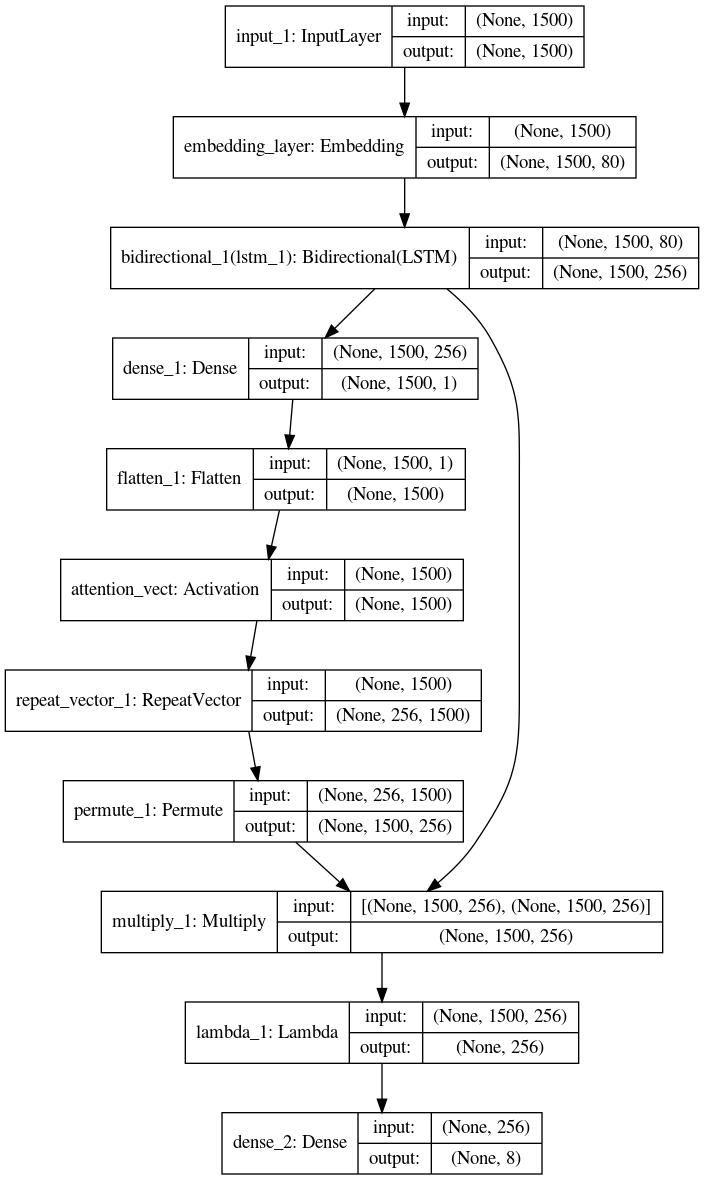

In [19]:
plot_model(model, to_file='models/1/model_plot.png', 
           show_shapes=True, show_layer_names=True)

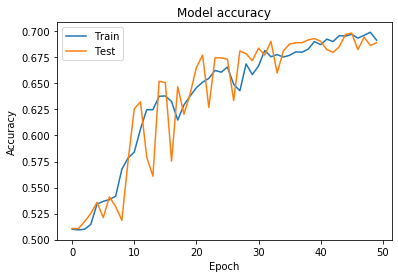

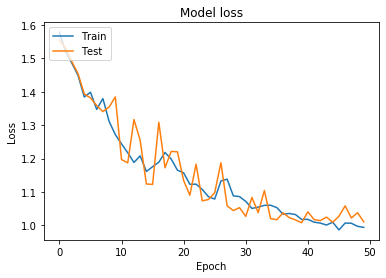

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
# load model
model = load_model('models/1/weights.45-1.01.hdf5')
# summarize model.
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1500)         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1500, 80)     1840        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 1500, 256)    214016      embedding_layer[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1500, 1)      257         bidirectional_1[0][0]            
____________________________________________________________________________________________

In [22]:
score = model.evaluate(x_valid_pad, y_valid_OH, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.009270809314869
Test accuracy: 0.6970899701118469


In [23]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

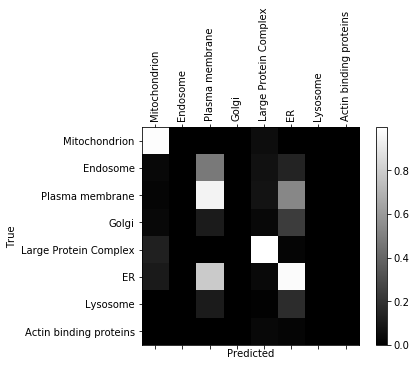

In [24]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
conf_mx

array([[ 85,   0,   0,   0,  20,   0,   0,   0],
       [  3,   0,   9,   0,  26,   7,   0,   0],
       [  2,   0,  18,   0,  29,  27,   0,   0],
       [  3,   0,   2,   0,  12,  12,   0,   0],
       [ 11,   0,   0,   0, 374,   1,   0,   0],
       [  9,   0,  15,   0,  14,  50,   0,   0],
       [  0,   0,   2,   0,   3,   9,   0,   0],
       [  0,   0,   0,   0,  12,   1,   0,   0]])

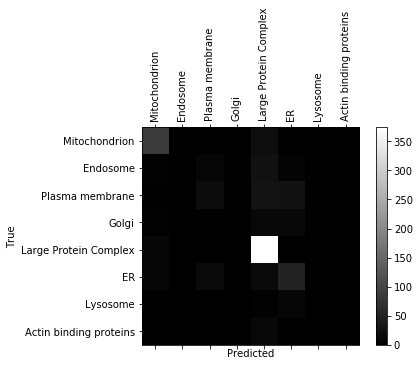

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Second Model: CNN LSTM

In [27]:
max_features = tot_aa + 1
batch_size = 64
#LSTM
units = 128
# Embedding
embedding_size = 128
# Convolution
kernel_size = 5
filters = 64
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', 
        trainable=True, mask_zero=False)(_input)

conv = Conv1D(filters, kernel_size, padding='same', activation='relu', 
              strides=1)(embedded)

pool = MaxPooling1D(pool_size=pool_size)(conv)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(pool)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(8, activation='softmax')(sent_representation)

In [29]:
model = Model(inputs=_input, outputs=probabilities)
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                           verbose=1, save_best_only=False)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=64, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/50
3022/3022 [==============================] - 177s 59ms/step - loss: 1.5577 - accuracy: 0.5083 - val_loss: 1.5152 - val_accuracy: 0.5106

Epoch 00001: saving model to models/2/weights.01-1.52.hdf5
Epoch 2/50
3022/3022 [==============================] - 225s 74ms/step - loss: 1.4697 - accuracy: 0.5175 - val_loss: 1.4407 - val_accuracy: 0.5159

Epoch 00002: saving model to models/2/weights.02-1.44.hdf5
Epoch 3/50
3022/3022 [==============================] - 186s 62ms/step - loss: 1.3848 - accuracy: 0.5460 - val_loss: 1.3593 - val_accuracy: 0.5489

Epoch 00003: saving model to models/2/weights.03-1.36.hdf5
Epoch 4/50
3022/3022 [==============================] - 165s 55ms/step - loss: 1.3394 - accuracy: 0.5649 - val_loss: 1.3011 - val_accuracy: 0.5926

Epoch 00004: saving model to models/2/weights.04-1.30.hdf5
Epoch 5/50
3022/3022 [==============================] - 159s 53ms/step - loss: 1.2924 - accuracy: 0.5807 - val_loss: 1.6384 -

3022/3022 [==============================] - 183s 61ms/step - loss: 0.7644 - accuracy: 0.7750 - val_loss: 1.0255 - val_accuracy: 0.7169

Epoch 00040: saving model to models/2/weights.40-1.03.hdf5
Epoch 41/50
3022/3022 [==============================] - 189s 63ms/step - loss: 0.7456 - accuracy: 0.7694 - val_loss: 1.0012 - val_accuracy: 0.7090

Epoch 00041: saving model to models/2/weights.41-1.00.hdf5
Epoch 42/50
3022/3022 [==============================] - 185s 61ms/step - loss: 0.7363 - accuracy: 0.7813 - val_loss: 1.0239 - val_accuracy: 0.6958

Epoch 00042: saving model to models/2/weights.42-1.02.hdf5
Epoch 43/50
3022/3022 [==============================] - 186s 62ms/step - loss: 0.7178 - accuracy: 0.7856 - val_loss: 0.9956 - val_accuracy: 0.6931

Epoch 00043: saving model to models/2/weights.43-1.00.hdf5
Epoch 44/50
3022/3022 [==============================] - 184s 61ms/step - loss: 0.7056 - accuracy: 0.7816 - val_loss: 1.0957 - val_accuracy: 0.6958

Epoch 00044: saving model to mo

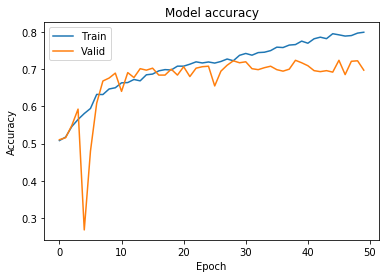

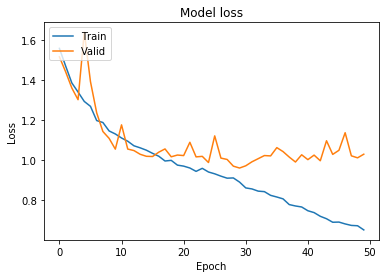

In [30]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

This model train faster but then dramatically overfit

In [32]:
model = load_model('models/2/weights.30-0.96.hdf5')

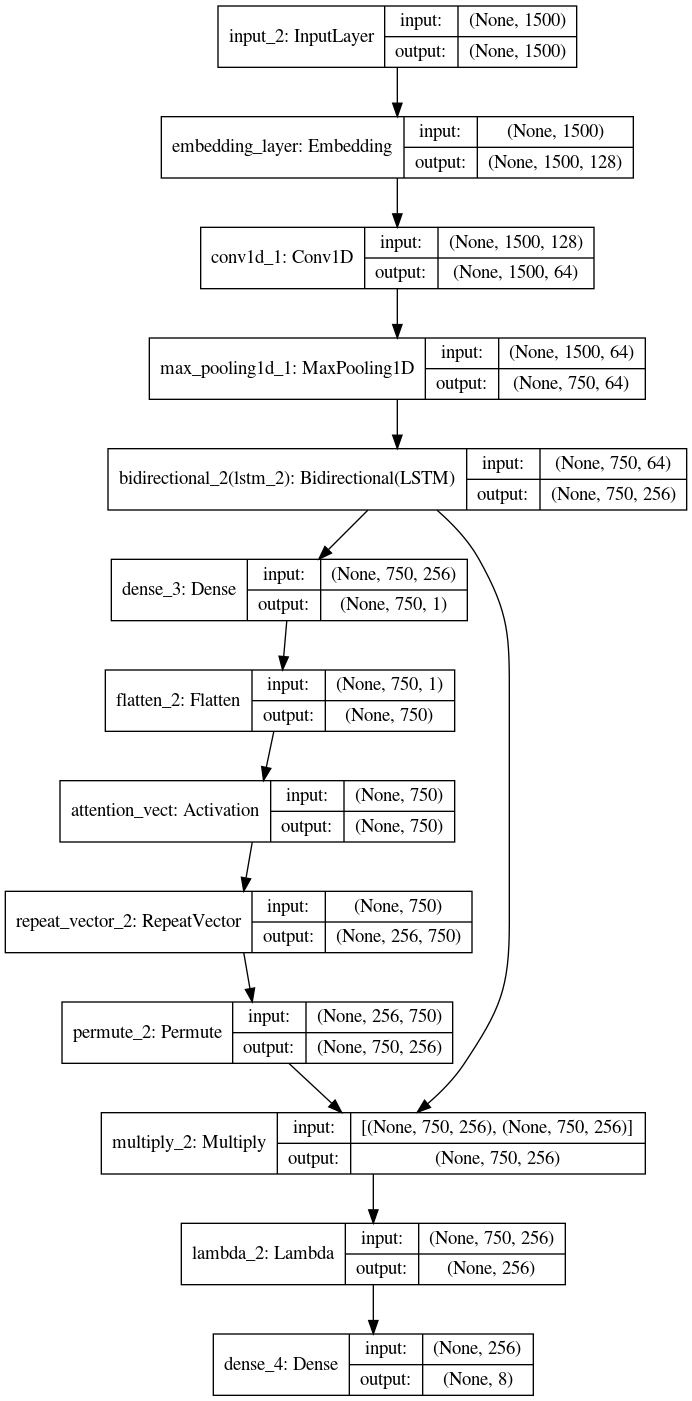

In [31]:
plot_model(model, to_file='models/2/model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [33]:
model.evaluate(x_valid_pad, y_valid_OH)

756/756 [==============================] - 14s 18ms/step


[0.9592236557965557, 0.7169312238693237]

In [34]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

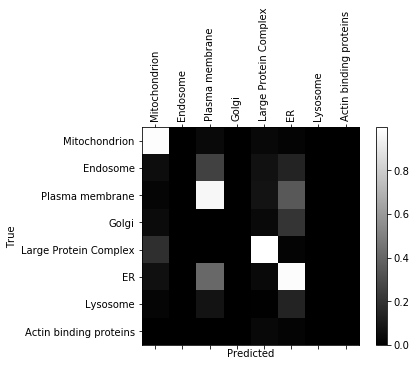

In [35]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
conf_mx

array([[ 91,   0,   1,   0,  12,   1,   0,   0],
       [  5,   0,   7,   0,  25,   8,   0,   0],
       [  2,   0,  26,   0,  28,  20,   0,   0],
       [  4,   0,   0,   0,  13,  12,   0,   0],
       [ 17,   0,   0,   0, 368,   1,   0,   0],
       [  6,   0,  11,   0,  14,  57,   0,   0],
       [  2,   0,   2,   0,   2,   8,   0,   0],
       [  0,   0,   0,   0,  12,   1,   0,   0]])

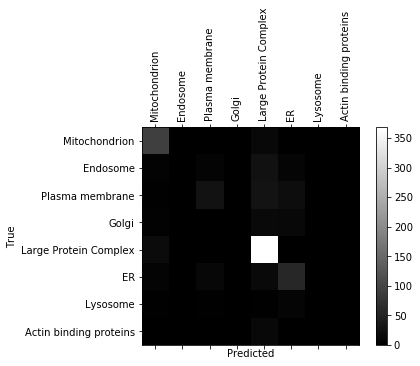

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

This model picked up something for the lysosome, the first model didn't

## Model 3: CNN LSTM

Concatenating several Conv1D

In [38]:
max_features = tot_aa + 1
batch_size = 64
#LSTM
units = 128
# Embedding
embedding_size = 40
# Convolution
kernel_size = 15
filters = 64
pool_size = 3

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', 
        trainable=True, mask_zero=False)(_input)

conv = Conv1D(filters, kernel_size, padding='same', activation='relu', 
              strides=1)(embedded)

pool = MaxPooling1D(pool_size=pool_size)(conv)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(pool)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(8, activation='softmax')(sent_representation)

In [40]:
model = Model(inputs=_input, outputs=probabilities)
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/3/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                           verbose=1, save_best_only=False)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=64, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3022 samples, validate on 756 samples
Epoch 1/50
3022/3022 [==============================] - 128s 42ms/step - loss: 1.5981 - accuracy: 0.4983 - val_loss: 1.6124 - val_accuracy: 0.5106

Epoch 00001: saving model to models/3/weights.01-1.61.hdf5
Epoch 2/50
3022/3022 [==============================] - 133s 44ms/step - loss: 1.4778 - accuracy: 0.5076 - val_loss: 1.4622 - val_accuracy: 0.5159

Epoch 00002: saving model to models/3/weights.02-1.46.hdf5
Epoch 3/50
3022/3022 [==============================] - 126s 42ms/step - loss: 1.3951 - accuracy: 0.5394 - val_loss: 1.3642 - val_accuracy: 0.5344

Epoch 00003: saving model to models/3/weights.03-1.36.hdf5
Epoch 4/50
3022/3022 [==============================] - 119s 39ms/step - loss: 1.3006 - accuracy: 0.5692 - val_loss: 1.3115 - val_accuracy: 0.5542

Epoch 00004: saving model to models/3/weights.04-1.31.hdf5
Epoch 5/50
3022/3022 [==============================] - 113s 37ms/step - loss: 1.2945 - accuracy: 0.5781 - val_loss: 1.2884 -

3022/3022 [==============================] - 115s 38ms/step - loss: 0.8258 - accuracy: 0.7555 - val_loss: 1.3125 - val_accuracy: 0.6601

Epoch 00040: saving model to models/3/weights.40-1.31.hdf5
Epoch 41/50
3022/3022 [==============================] - 117s 39ms/step - loss: 0.8487 - accuracy: 0.7445 - val_loss: 0.9677 - val_accuracy: 0.7249

Epoch 00041: saving model to models/3/weights.41-0.97.hdf5
Epoch 42/50
3022/3022 [==============================] - 111s 37ms/step - loss: 0.8133 - accuracy: 0.7574 - val_loss: 1.1987 - val_accuracy: 0.6627

Epoch 00042: saving model to models/3/weights.42-1.20.hdf5
Epoch 43/50
3022/3022 [==============================] - 111s 37ms/step - loss: 0.8220 - accuracy: 0.7522 - val_loss: 0.9770 - val_accuracy: 0.7249

Epoch 00043: saving model to models/3/weights.43-0.98.hdf5
Epoch 44/50
3022/3022 [==============================] - 110s 36ms/step - loss: 0.7962 - accuracy: 0.7601 - val_loss: 0.9679 - val_accuracy: 0.7275

Epoch 00044: saving model to mo

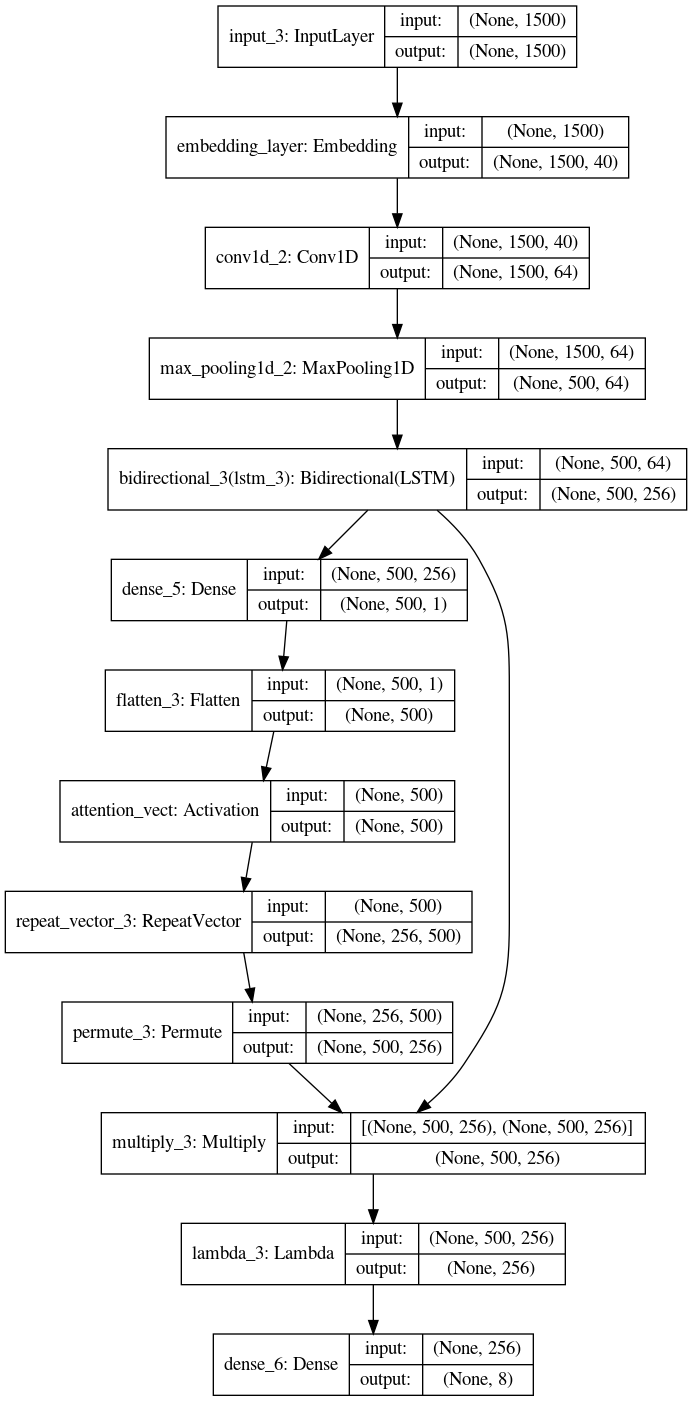

In [41]:
plot_model(model, to_file='models/3/model_plot.png', 
           show_shapes=True, show_layer_names=True)

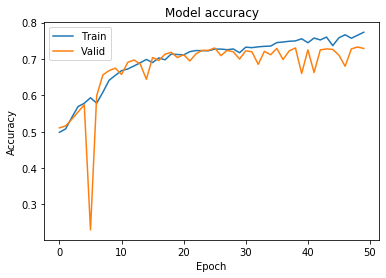

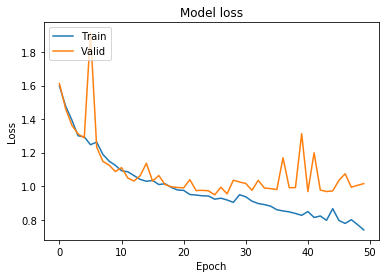

In [43]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [44]:
model = load_model('models/3/weights.26-0.95.hdf5')

In [45]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

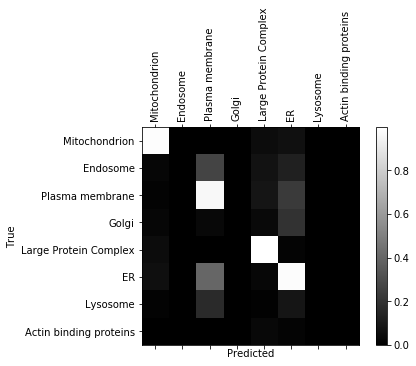

In [46]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()